### Plot Signals

In [2]:
import pandas as pd
import numpy as np
import plotting_util

df = pd.read_parquet("out/can_data.parquet")
subject_006 = df[(df['subject_id'] == '006') & (df['subject_state'] == 'sober') & (df['subject_scenario'] == 'town')]

In [6]:
from math import ceil
from scipy.stats import kurtosis
from scipy.signal import find_peaks, peak_widths

def mean_peak_heights(x):
    _, props = find_peaks(x, height=0, width=1, plateau_size=0)
    return np.mean(props['peak_heights'])

def mean_peak_widths(x):
    ind, _ = find_peaks(x, height=0, width=1, plateau_size=0)
    widths, _, _, _ = peak_widths(x, ind)
    return np.mean(widths)

def brake_to_gas(x):
    gas = x[x['gas'] > 0]['gas']
    if not gas.empty:
        ind = gas.index.to_numpy()[0]
        first = x['timestamp'].index.to_numpy()[0]
        return (x['timestamp'].at[ind] - x['timestamp'].at[first]).total_seconds()
    else:
        return np.nan

def gas_to_brake(x):
    brake = x[x['brake'] > 0]['brake']
    if not brake.empty:
        ind = brake.index.to_numpy()[0]
        first = x['timestamp'].index.to_numpy()[0]
        return pd.Series({'gas_to_brake': (x['timestamp'].at[ind] - x['timestamp'].at[first]).total_seconds()})
    else:
        return pd.Series({'gas_to_brake': np.nan})

def distance_covered(x, signal):
    if (x[signal] == 0).all():
        first = x['timestamp'].index.to_numpy()[0]
        last = x['timestamp'].index.to_numpy()[-1]
        return pd.Series({'distance_covered': x['velocity'].mean() * (x['timestamp'].at[last] - x['timestamp'].at[first]).total_seconds()})
    else:
        return pd.Series({'distance_covered': np.nan})

def calc_lane_switching(row):
        # check 5 seconds after lane crossing started if the lane number changes exactly once to indicate intended lane switching
        counts = subject_006.iloc[row.name:row.name+150]['lane_number'].diff().abs().value_counts()
        return (counts[1] == 1).astype(int) if 1 in counts else 0

def indicator_behavior(row):
        indicator_usage = (subject_006.iloc[row.name:row.name+150]['indicator_left'] | subject_006.iloc[row.name:row.name+150]['indicator_right']).astype(int)

test = subject_006[(subject_006['steer'] <= -10) | (subject_006['steer'] >= 10)].index.values
groups = [[test[0]]]
for x in test[1:]:
    if x == groups[-1][-1] + 1:
        groups[-1].append(x)
    else:
        groups.append([x])


def merge_maneuvers(groups, idx):
    if len(groups) == 1:
        return groups
    if idx == len(groups)-1:
        return groups
    if groups[idx+1][0] - groups[idx][-1] <= 90:
        new_groups = groups[:idx] + [groups[idx] + groups[idx+1]] + groups[idx+2:]
        return merge_maneuvers(new_groups, idx)
    else:
        return merge_maneuvers(groups, idx+1)

turning_indices = merge_maneuvers(groups, 0)
    # if len(prev) % 2 == 1:
    #     turning_indices.append(prev[-1])
#print(groups)
print(turning_indices)

# res1 = (subject_006[subject_006['gas'] > 0]
#                 .groupby((subject_006['gas'] == 0).cumsum(), as_index=False))
#print(res1.apply(lambda x: print(x)))

# res3 = (subject_006[subject_006['gas'] > 0]
#                 .groupby((subject_006['gas'] == 0).cumsum(), as_index=False)
#                 .filter(lambda x: (x['brake'] == 0).all())
#                 .groupby((subject_006['gas'] == 0).cumsum(), as_index=False))
# print(res3.apply(lambda x: print(x)))
# test1 = subject_006[subject_006['lane_number'] == 1].groupby((subject_006['lane_number'] == 0).cumsum(), as_index=False)
# res = test1.apply(
#     overtaking_event
#  )
# print(res)

[[1, 2, 3], [150, 151, 152]]


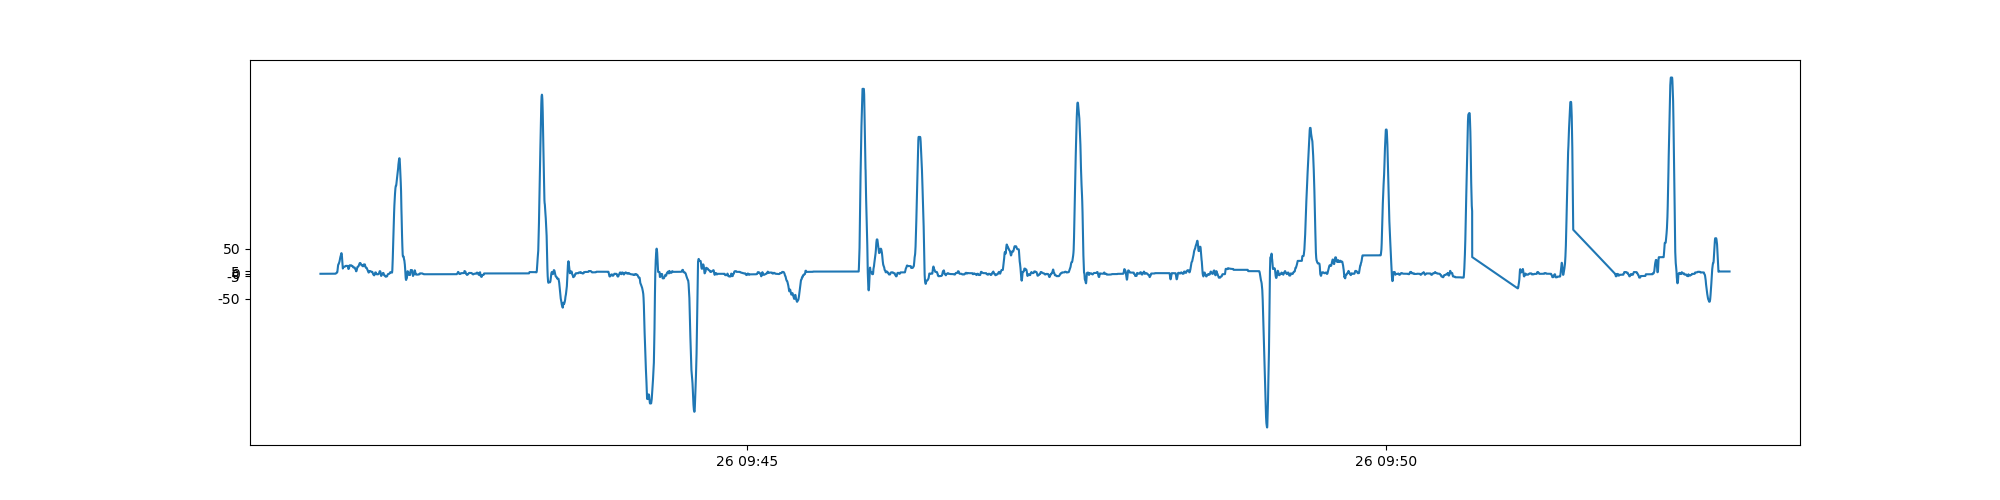

In [17]:
%matplotlib widget
times = subject_006['timestamp']

fig, ax = plotting_util.create_plot(1, 1)
ax.plot(times, subject_006['steer'])
plotting_util.set_figure_size(fig, 20, 5)
plotting_util.set_plot_yticks(ax, [-50, -5, 0, 5, 50], ['-50', '-5', '0', '5', '50'])

In [8]:
times = subject_006['timestamp']

nr_df_cols = len(subject_006.iloc[:, 5:].columns)
nr_rows = ceil(nr_df_cols / 2.0)
nr_cols = 2

fig, axes = plotting_util.create_plot(nr_rows, nr_cols, True, False)
for axs, row in zip(axes, list(range(nr_rows))):
    for ax, col in zip(axs, list(range(nr_cols))):
        plotting_util.set_plot_axis_labels(ax, '', '')
        plotting_util.set_plot_title(ax, subject_006.iloc[:, 4+2*row+col].name)
        ax.plot(times, subject_006.iloc[:, 4+2*row+col])
plotting_util.set_figure_size(fig, 20, 50)

NameError: name 'ceil' is not defined

### Plot Segment Positions

In [ ]:
import pandas as pd
import plotting_util
%matplotlib widget
lanes_df = pd.read_csv('out/scenario_information.csv')
lanes_df = lanes_df.loc[lanes_df['scenario'] == 'highway']
fig, ax = plotting_util.create_plot(1,1)
for _, row in lanes_df.iterrows():
    ax.plot([row['StartPos_x_segment'], row['EndPos_x_segment']], [row['StartPos_y_segment'], row['EndPos_y_segment']], 'o-')
plotting_util.set_figure_size(fig, 20, 20)

### ID Image Thresholding

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv

img = cv.imread('out/20210901_d-011_above/error_segment_1927394.0.jpg')
imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
mask = cv.inRange(imhsv, (0, 50, 0), (179, 255, 255))
img_no_artifacts = cv.bitwise_and(img, img, mask=mask)
imgray = cv.cvtColor(img_no_artifacts, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(imgray, 127, 255, cv.THRESH_BINARY)
plt.imshow(thresh)

### None Counting for Segment IDs

In [1]:
import pandas as pd
import glob
import re


DATA_FOLDER = '/adar/drive/study'

subject_folders = sorted(glob.glob(DATA_FOLDER + '/*_sober') + glob.glob(DATA_FOLDER + '/*_above') + glob.glob(
            DATA_FOLDER + '/*_below'))
subject_folders = [f for f in subject_folders if 'audio' not in f]

scenarios = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')

subject_re = re.compile('d-([0-9]+)')
for subject in subject_folders:
    subject_id_match = subject_re.search(subject)
    if not subject_id_match:
        continue
    subject_id = subject_id_match.group(1)

    if "drunk" in subject:
        state = "drunk"
    elif "above" in subject:
        state = "above"
    elif "below" in subject:
        state = "below"
    else:
        state = "sober"

    for scenario in scenarios: 
        can_data_for_subject = can_data.loc[(can_data['subject_id'] == subject_id) & (can_data['subject_state'] == state) & (can_data['subject_scenario'] == scenario)]
        print('subject_id: {}, state: {}, scenario: {}'.format(subject_id, state, scenario))
        print(can_data_for_subject['segment_id'].isna().sum())

subject_id: 006, state: above, scenario: highway
0
subject_id: 006, state: above, scenario: rural
0
subject_id: 006, state: above, scenario: town
0
subject_id: 006, state: below, scenario: highway
224
subject_id: 006, state: below, scenario: rural
0
subject_id: 006, state: below, scenario: town
0
subject_id: 006, state: sober, scenario: highway
4
subject_id: 006, state: sober, scenario: rural
0
subject_id: 006, state: sober, scenario: town
0
subject_id: 001, state: above, scenario: highway
0
subject_id: 001, state: above, scenario: rural
675
subject_id: 001, state: above, scenario: town
0
subject_id: 001, state: below, scenario: highway
153
subject_id: 001, state: below, scenario: rural
0
subject_id: 001, state: below, scenario: town
0
subject_id: 001, state: sober, scenario: highway
5
subject_id: 001, state: sober, scenario: rural
0
subject_id: 001, state: sober, scenario: town
0
subject_id: 011, state: above, scenario: highway
74
subject_id: 011, state: above, scenario: rural
0
subje

### Lane Position Validation

In [5]:
import pandas as pd
import glob
import re
import cv2 as cv
import random
import datetime
import pytz
import os

DATA_FOLDER = '/adar/drive/study'

subject_folders = sorted(glob.glob(DATA_FOLDER + '/*_sober') + glob.glob(DATA_FOLDER + '/*_above') + glob.glob(
            DATA_FOLDER + '/*_below'))
subject_folders = [f for f in subject_folders if 'audio' not in f]

selected_folders = random.sample(subject_folders, 5)
scenarios = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')

subject_re = re.compile('d-([0-9]+)')
timestamp_re = re.compile(r'(\d{4})-(\d{2})-(\d{2})--(\d{2})-(\d{2})-(\d{2}).flv')
for subject in selected_folders:
    subject_id_match = subject_re.search(subject)
    if not subject_id_match:
        continue
    subject_id = subject_id_match.group(1)

    if "drunk" in subject:
        state = "drunk"
    elif "above" in subject:
        state = "above"
    elif "below" in subject:
        state = "below"
    else:
        state = "sober"

    scenario = random.choice(scenarios)
    can_data_for_subject = can_data.loc[(can_data['subject_id'] == subject_id) & (can_data['subject_state'] == state) & (can_data['subject_scenario'] == scenario)]

    print('subject folder: {}, subject_id: {}, state: {}, scenario: {}'.format(subject, subject_id, state, scenario))
    
    for video in glob.glob(subject + '/obs-videos/*[!_cropped].flv'):
        print('video: {}'.format(video.split('/')[-1]))
        match = timestamp_re.search(video.split('/')[-1])
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
            day = int(match.group(3))
            hour = int(match.group(4))
            minute = int(match.group(5))
            second = int(match.group(6))
            video_timestamp = datetime.datetime(year, month, day, hour, minute, second)
            tz = pytz.timezone('Europe/Zurich')
            video_timestamp = tz.localize(video_timestamp)
            can_data_lane = can_data_for_subject[['timestamp', 'latpos', 'segment_id', 'lane_number', 'lane_position', 'lane_distance_left_edge', 'lane_distance_right_edge']].copy()
            can_data_lane.loc[:, 'timestamp'] = (can_data_lane['timestamp'] - video_timestamp) / datetime.timedelta(milliseconds=1)
            sampled_values = can_data_lane.sample(10).sort_values(by='timestamp').to_numpy()
            cap = cv.VideoCapture(video)
            index = 0
            for timestamp_ms, latpos, segment_id, lane_nr, lane_pos, distance_left_edge, distance_right_edge in sampled_values:
                folder = 'out/' + subject.split('/')[-1]
                if not os.path.exists(folder):
                    os.makedirs(folder)
                is_set = cap.set(cv.CAP_PROP_POS_MSEC, timestamp_ms)
                if is_set:
                    success, frame = cap.read()
                    if success:
                        print('success')
                        img = cv.putText(frame, 'latpos: {}'.format(latpos), (1300, 1200), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(frame, 'segment id: {}'.format(segment_id), (1300, 1300), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane nr: {}'.format(lane_nr), (1300, 1400), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane pos: {}'.format(lane_pos), (1300, 1500), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'distance left edge: {}'.format(distance_left_edge), (1300, 1600), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'distance right edge: {}'.format(distance_right_edge), (1300, 1700), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        cv.imwrite(folder + '/img{}-{}-{}.png'.format(index, scenario, timestamp_ms / 1000.0), img)
                        index += 1
                    else:
                        print('could not get frame')
                else:
                    print('could not set video timestamp')

subject folder: /adar/drive/study/20211029_d-024_below, subject_id: 024, state: below, scenario: highway
video: 2021-10-29--15-06-08.flv
success
success
success
success
success
success
success
success
success
success
